In [18]:
# Stiff Robertson's problem from chemical kinetics as in
# https://openmdao.github.io/dymos/examples/robertson_problem/robertson_problem.html

import numpy as np
import matplotlib.pyplot as plt
import time

In [32]:
a = 0.04
b = 1.0e4
c = 3.0e7

# coefficients for BDF2:
# u_{n+1} + alpha_0*u_n + alpha_1*u_{n-1} = h*beta_{-1}f_{n+1}
bm1 = 2/3 # beta_{-1}
a0 = -4/3 # alpha_0
a1 = 1/3 # alpha_1

# timestep, Tmax, tolearnce for Newton's solver
h = 0.001
Tmax = 40.0
Nsteps = int(np.ceil(Tmax/h))
tol = 1.0e-14
itermax = 20

# the right-hand side
def func(y): 
    dy = np.zeros(3)
    byz = b*y[1]*y[2]
    cy2 = c*y[1]*y[1]
    ax = a*y[0]
    dy[0] = -ax + byz
    dy[1] = ax - byz - cy2
    dy[2] = cy2
    return dy

# the Jacobian matrix for the right-hand side
def Jac(y):
    by = b*y[1]
    bz = b*y[2]
    c2y = 2*c*y[1]
    Jac = np.zeros((3,3))
    Jac[0,0] = -a
    Jac[0,1] = bz
    Jac[0,2] = by
    Jac[1,0] = a
    Jac[1,1] = -bz-c2y
    Jac[1,2] = -by
    Jac[2,1] = c2y
    return Jac

y0 = np.array([1.0,0.0,0.0])

def NewtonIterBDF(y,yn,yn1,h):
    # yn = y(t_n)
    # yn1 = y(t_{n-1})
    F = y - bm1*h*func(y) + a0*yn + a1*yn1
    DF = np.identity(3) - bm1*h*Jac(y)
    return y - np.linalg.solve(DF,F)

gamma = 1.0 - 1.0/np.sqrt(2)

def NewtonIterDIRK2_k1(y,h,k1):
    aux = y + h*gamma*k1
    F = k1 - func(aux)
    DF = np.identity(3) - h*gamma*Jac(aux)
    return k1 - np.linalg.solve(DF,F)

def NewtonIterDIRK2_k2(y,h,k1,k2):
    aux = y + h*((1-gamma)*k1 + gamma*k2)
    F = k2 - func(aux)
    DF = np.identity(3) - h*gamma*Jac(aux)
    return k2 - np.linalg.solve(DF,F)

def DIRK2step(y,h):
    k1 = func(y)
    for j in range(itermax):
        k1 = NewtonIterDIRK2_k1(y,h,k1)
        if np.linalg.norm(k1 - func(y + h*gamma*k1)) < tol:
            break
    # print( np.linalg.norm(k1 - func(y + h*gamma*k1)))
    # print(j)
    k2 = k1
    for j in range(itermax):
        k2 = NewtonIterDIRK2_k2(y,h,k1,k2)
        aux = y + h*((1-gamma)*k1 + gamma*k2)
        if np.linalg.norm(k2 - func(aux)) < tol:
            break
    # print( np.linalg.norm(k2 - func(aux)))
    # print(j)
    return aux

def BDF2step(y_last1,y_last2,h):
    y = y_last1
    for j in range(itermax):
        F = y - 2/3*h*func(y) - 4/3*y_last1 + 1/3*y_last2
        if np.linalg.norm(F) < tol:
            break
        DF = np.identity(3) - 2/3*h*Jac(y)
        y = y - np.linalg.solve(DF,F)
    return y

In [40]:
t = np.arange(0,(Nsteps+1)*h,h)

sol_dirk = np.zeros((Nsteps+1,3))
sol_dirk[0,:] = y0
sol_dirk[1,:] = DIRK2step(y0,h)

start_time = time.time()
for j in range(1,Nsteps):
    sol_dirk[j+1,:] = DIRK2step(sol_dirk[j,:],h)
print("DIRK2 time",time.time()-start_time)

DIRK2 time 2.6727588176727295


In [41]:
sol_bdf = np.zeros((Nsteps+1,3))
sol_bdf[0,:] = y0
sol_bdf[1,:] = DIRK2step(y0,h)

start_time = time.time()
for j in range(1,Nsteps):
    sol_bdf[j+1,:] = BDF2step(sol_bdf[j,:],sol_bdf[j-1,:],h)
print("BDF2 time",time.time()-start_time)

BDF2 time 2.015164375305176


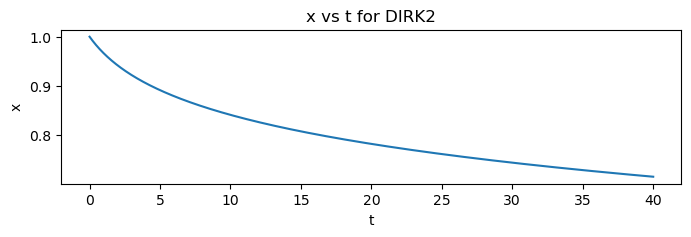

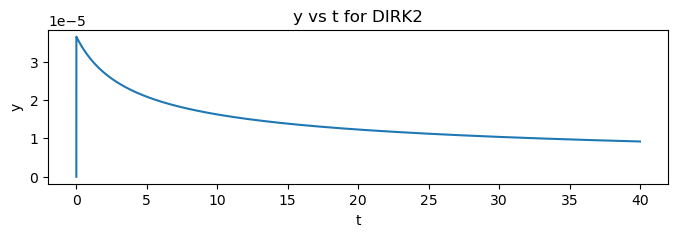

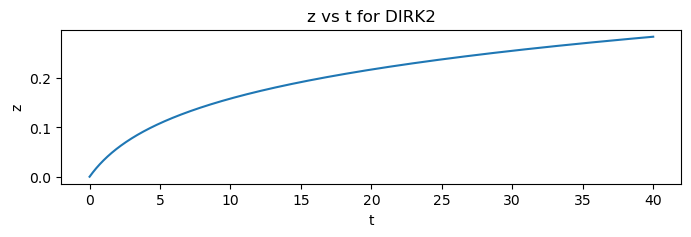

In [49]:
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(figsize = (8,2))
plt.plot(t,sol_dirk[:,0])
plt.ylabel("x")
plt.xlabel("t")
plt.title("x vs t for DIRK2")
plt.savefig("hw4 dirk x.png")
fig, ax = plt.subplots(figsize = (8,2))
plt.plot(t,sol_dirk[:,1])
plt.ylabel("y")
plt.xlabel("t")
plt.title("y vs t for DIRK2")
plt.savefig("hw4 dirk y.png")
fig, ax = plt.subplots(figsize = (8,2))
plt.plot(t,sol_dirk[:,2])
plt.ylabel("z")
plt.xlabel("t")
plt.title("z vs t for DIRK2")
plt.savefig("hw4 dirk z.png")

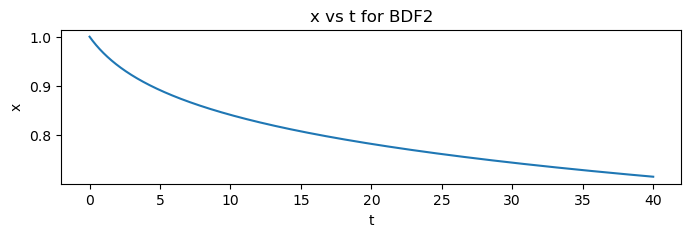

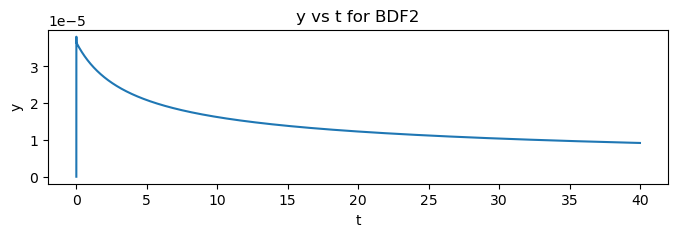

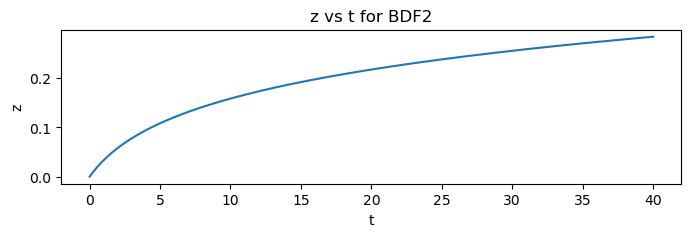

In [48]:
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(figsize = (8,2))
plt.plot(t,sol_bdf[:,0])
plt.ylabel("x")
plt.xlabel("t")
plt.title("x vs t for BDF2")
plt.savefig("hw4 bdf x.png")
fig, ax = plt.subplots(figsize = (8,2))
plt.plot(t,sol_bdf[:,1])
plt.ylabel("y")
plt.xlabel("t")
plt.title("y vs t for BDF2")
plt.savefig("hw4 bdf y.png")
fig, ax = plt.subplots(figsize = (8,2))
plt.plot(t,sol_bdf[:,2])
plt.ylabel("z")
plt.xlabel("t")
plt.title("z vs t for BDF2")
plt.savefig("hw4 bdf z.png")